In [1]:
#@markdown **NVIDIA GPU**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

Tesla T4, 15360 MiB, 15101 MiB


# Setup

In [2]:
#@markdown **Environment Setup**
import subprocess, time, gc, os, sys

def setup_environment():
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'

    if 'google.colab' in str(ipy):
        start_time = time.time()
        packages = [
            'xformers==0.0.24',
            'einops==0.4.1 pytorch-lightning==1.7.7 torchdiffeq==0.2.3 torchsde==0.2.5',
            'ftfy timm transformers open-clip-torch omegaconf torchmetrics==0.11.4',
            'safetensors kornia accelerate jsonmerge matplotlib resize-right',
            'scikit-learn numpngw pydantic'
        ]
        for package in packages:
            print(f"..installing {package}")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + package.split())
        if not os.path.exists("deforum-stable-diffusion"):
            subprocess.check_call(['git', 'clone', '-b', '0.7.1', 'https://github.com/deforum-art/deforum-stable-diffusion.git'])
        else:
            print(f"..deforum-stable-diffusion already exists")
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend(['deforum-stable-diffusion/','deforum-stable-diffusion/src',])
        end_time = time.time()
        print(f"..environment set up in {end_time-start_time:.0f} seconds")
    else:
        sys.path.extend(['src'])
        print("..skipping setup")

setup_environment()

import torch
import random
import clip
from IPython import display
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
from helpers.prompts import Prompts

..installing xformers==0.0.24
..installing einops==0.4.1 pytorch-lightning==1.7.7 torchdiffeq==0.2.3 torchsde==0.2.5
..installing ftfy timm transformers open-clip-torch omegaconf torchmetrics==0.11.4
..installing safetensors kornia accelerate jsonmerge matplotlib resize-right
..installing scikit-learn numpngw pydantic
..environment set up in 206 seconds


In [3]:
#@markdown **Path Setup**

def PathSetup():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
    return locals()

root = SimpleNamespace(**PathSetup())
root.models_path, root.output_path = get_model_output_paths(root)

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [4]:
#@markdown **Model Setup**

def ModelSetup():
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "v1-inference.yaml" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "Protogen_V2.2.ckpt" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "" #@param {type:"string"}
    custom_checkpoint_path = "" #@param {type:"string"}
    return locals()

root.__dict__.update(ModelSetup())
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location=root.map_location)

..attempting to download Protogen_V2.2.ckpt...this may take a while


Protogen_V2.2.ckpt: 100%|██████████| 4.27G/4.27G [01:26<00:00, 49.6MB/s]


config_path: /content/deforum-stable-diffusion/configs/v1-inference.yaml
ckpt_path: /content/drive/MyDrive/AI/models/Protogen_V2.2.ckpt
..checking sha256
..hash is correct
..loading model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

# Settings

In [5]:
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '2D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 180 #@param {type:"number"}
    border = 'replicate' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0:(1),10(-3)"#@param {type:"string"}
    zoom = "0:(1.0025+0.002*sin(1.25*3.14*t/30))"#@param {type:"string"}
    translation_x = "0:(0)"#@param {type:"string"}
    translation_y = "0:(0)"#@param {type:"string"}
    translation_z = "0:(1.0025+0.002*sin(1.25*3.14*t/30))"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0:(0)"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.2)"#@param {type:"string"}
    strength_schedule = "0: (0.65)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '2' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 40#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = True #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 6 #@param {type:"number"}

    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20220829210106" #@param {type:"string"}

    return locals()

In [6]:
# prompts
prompts = {
0: "A stunning android woman in a radiant pastel palette, dynamic and illuminated scene, digital art masterpiece by Victo Ngai and Kilian Eng, breathtakingly beautiful illustration.",
30: "A sleek sportscar on a sunlit beach, rendered in vivid pastel tones, epic scene by Victo Ngai and Kilian Eng, dynamic lighting, award-winning digital art, exquisitely beautiful illustration.",
60: "A picturesque village of charming huts in soft pastel hues, vibrant and lively scene by Victo Ngai and Kilian Eng, dynamic lighting, award-winning digital masterpiece.",
90: "An exquisite flower captured in a top-trending Artstation style.",
120: "A cozy, modern city coffee shop bathed in warm city lights.",
150: "A young boy joyfully playing in the street with friends in a lively urban setting."
}

neg_prompts = {
    0: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    30: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    60: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    90: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    120: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry",
    150: "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
}

# can be a string, list, or dictionary
#prompts = [
#    "a beautiful lake by Asher Brown Durand, trending on Artstation",
#    "a beautiful portrait of a woman by Artgerm, trending on Artstation",
#]
#prompts = "a beautiful lake by Asher Brown Durand, trending on Artstation"

Install Library

In [7]:
!pip install -q --upgrade diffusers invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00


Run pipeline

In [8]:
import torch
from torch import autocast
from diffusers import StableDiffusionXLPipeline, EulerAncestralDiscreteScheduler

model = "linaqruf/animagine-xl"

pipe = StableDiffusionXLPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')

model_index.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "linaqruf/animagine-xl",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Generate starting image

  0%|          | 0/50 [00:00<?, ?it/s]

(-0.5, 1023.5, 1023.5, -0.5)

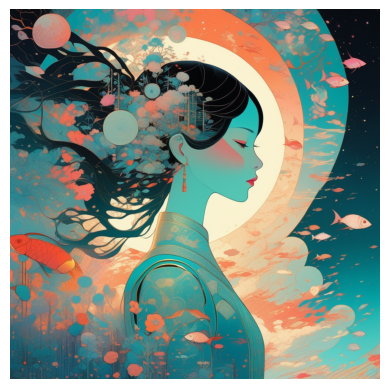

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

prompt = "A beautiful woman robot android, bright pastel colours, epic scene, by Victo Ngai, Kilian Eng vibrant colours, dynamic lighting, digital art, winning award masterpiece, fantastically beautiful, illustration, aesthetically inspired"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
output = "/content/first_img.png"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    width=1024,
    height=1024,
    guidance_scale=12,
    target_size=(1024,1024),
    original_size=(4096,4096),
    num_inference_steps=50
    ).images[0]

image.save(output)
image = Image.open(output)
plt.imshow(image)
plt.axis('off') # to hide the axis

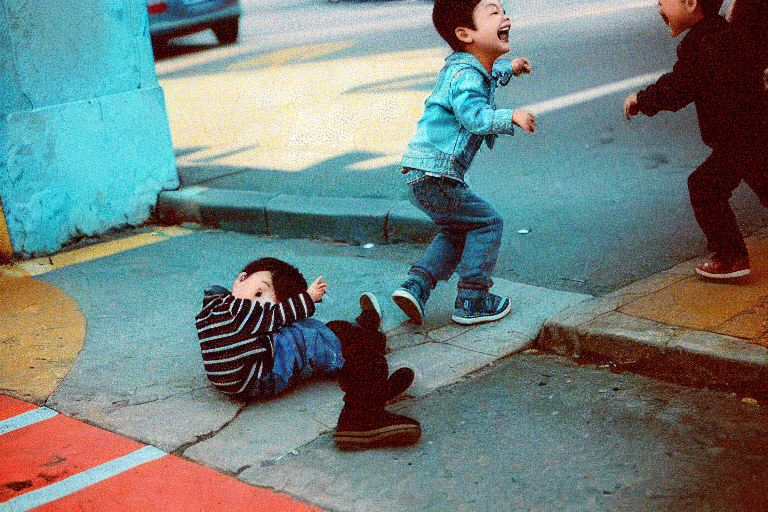

In [10]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 768 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}

    #@markdown **Sampling Settings**
    seed = 2000 #@param
    sampler = 'dpm2' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 50 #@param
    scale = 10 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = True #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = True #@param {type:"boolean"}
    strength = 0.70 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "/content/first_img.png" #@param {type:"string"}
    add_init_noise = False #@param {type:"boolean"}
    init_noise = 0.02 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}

    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = True #@param {type:"boolean"}
    precision = 'autocast'
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# get prompts
cond, uncond = Prompts(prompt=prompts,neg_prompt=neg_prompts).as_dict()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond, uncond)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond, uncond)
else:
    render_image_batch(root, args, cond, uncond)

In [9]:
def create_video(skip_video_for_run_all=False, fps=12, use_manual_settings=False, render_steps=True, path_name_modifier="x0_pred"):
    import os
    import subprocess
    from base64 import b64encode
    from IPython import display

    if skip_video_for_run_all:
        print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
        return

    if use_manual_settings:
        image_path = "/content/drive/MyDrive/AI/StableDiffusion/2024-04/StableFun/20240430230300_%05d.png"
        mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2024-04/20220903000939.mp4"
        max_frames = "180"
    else:
        if render_steps:
            # Simulating a scenario where you determine paths based on latest directory etc.
            # You would need to replace these with specific logic to define `image_path` and `mp4_path`.
            outdir = "/content/drive/MyDrive/AI/StableDiffusion/2024-04"  # Example output directory
            image_path = os.path.join(outdir, f"{path_name_modifier}_%05d.png")
            mp4_path = os.path.join(outdir, f"{path_name_modifier}.mp4")
            max_frames = "180"  # Example maximum frames
        else:
            outdir = "/content/drive/MyDrive/AI/StableDiffusion/2024-04"
            image_path = os.path.join(outdir, "20220903000939_%05d.png")
            mp4_path = os.path.join(outdir, "20220903000939.mp4")
            max_frames = "180"

    print(f"{image_path} -> {mp4_path}")

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', '0',
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf', f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        mp4_path
    ]

    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    if process.returncode != 0:
        print(stderr.decode())
        return

    try:
        mp4 = open(mp4_path, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>'))
    except Exception as e:
        print(f"Failed to load video file: {e}")

# Example usage
create_video(use_manual_settings=True)


/content/drive/MyDrive/AI/StableDiffusion/2024-04/StableFun/20240430230300_%05d.png -> /content/drive/MyDrive/AI/StableDiffusion/2024-04/20220903000939.mp4


In [10]:
!pip install torch==2.1.0
!pip install torchvision==0.13.1


  Using cached torchvision-0.13.1-cp310-cp310-manylinux1_x86_64.whl (19.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.12.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.12.1 which is incompatible.
xformers 0.0.24 requires torch==2.2.0, but you have torc

In [11]:
# @markdown # Setup of music generation
!pip install 'torch>=2.0'
!pip install -U git+https://git@github.com/facebookresearch/audiocraft#egg=audiocraft

import math
import IPython
import soundfile as sf
import numpy as np
from tqdm.notebook import tqdm

from audiocraft.models import MusicGen
from audiocraft.models import MultiBandDiffusion
from audiocraft.utils.notebook import display_audio
import torch
import torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.18.1
    Uninstalling nvidia-nccl-cu12-2.18.1:
      Successfully uninstalled nvidia-nccl-cu12-2.18.1
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.3.0 which is incomp

## Load model

In [12]:
# @markdown ### Select model
# @markdown 1. `facebook/musicgen-small` - 300M transformer decoder. Generates audio at speed 1/2, it takes 2 minutes to generate 1 minute of audio
# @markdown 2. `facebook/musicgen-medium` - 1.5B transformer decoder. Generates audio at speed 1/4
# @markdown 3. `facebook/musicgen-melody` - 1.5B transformer decoder also supporting melody conditioning.
# @markdown 4. `facebook/musicgen-large` - 3.3B transformer decoder. Generates audio at speed 1/4

model_size = 'large' # @param ["small", "medium", "melody", "large"]
USE_DIFFUSION_DECODER = False # @param ["False", "True"] {type:"raw"}
model = MusicGen.get_pretrained(f'facebook/musicgen-{model_size}')
if USE_DIFFUSION_DECODER:
    mbd = MultiBandDiffusion.get_mbd_musicgen()

class ProgressCallback():
    def __init__(self):
        self.tqdm = None
        self.progress = 0

    def __call__(self, progress, total):
        if progress == 1:
            self.tqdm = tqdm(total=total)
            self.progress = 0
        self.tqdm.update(progress - self.progress)
        self.progress = progress
        if progress >= total:
            self.tqdm.close()

model.set_custom_progress_callback(ProgressCallback())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


state_dict.bin:   0%|          | 0.00/6.51G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

compression_state_dict.bin:   0%|          | 0.00/236M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


### Define prompts

Create a list with the prompts you want to use to generate audio.

Create a list with the prompts you want to use to generate audio.

In [22]:
prompts = [
"Feel the groove as a jazz trio dazzles under city lights, weaving magic through soulful melodies in an enchanting urban night scene."
]

# Disconnect Runtime

In [23]:
# @markdown #### Generate audio
# @markdown Select the audio duration in seconds for each prompt and the overlap
# @markdown If using the T4 GPU it should be possible to generate audio of arbitrary duration, but the prompts could not be longer than ~3 minutes

prompt_duration = 15 # @param {type:"integer"}
overlap = 10 # @param {type:"integer"}
output_filepath = 'audio2.mp3' # @param {type:"string"}
display_intermediate_results = True # @param ["False", "True"] {type:"raw"}

model.set_generation_params(
    use_sampling=True,
    top_k=250,
    duration=int(overlap + prompt_duration),
)

def generate_audio_with_multiple_prompts(prompts, overlap=2, sr=32000, verbose=False):
    torch_audio = generate_audio_with_prompt(prompts[0])[..., :-int(sr*overlap)]
    audio = torch_audio.cpu().numpy().squeeze()
    print(prompts[0])
    for prompt in prompts[1:]:
        if verbose: IPython.display.display(IPython.display.Audio(audio, rate=sr))
        print(prompt)
        torch_audio = continue_audio_with_prompt(torch_audio, prompt, overlap, sr)
        audio = np.concatenate([audio, torch_audio.cpu().numpy().squeeze()[int(sr*overlap):]])
    IPython.display.display(IPython.display.Audio(audio, rate=sr))
    return audio

def generate_audio_with_prompt(prompt):
    output = model.generate(
        descriptions=[prompt],
        progress=True, return_tokens=True
    )
    if USE_DIFFUSION_DECODER:
        audio = mbd.tokens_to_wav(output[1])
    else:
        audio = output[0]
    return audio

def continue_audio_with_prompt(input_audio, prompt, overlap=2, sr=32000):
    output = model.generate_continuation(
        input_audio[..., -int(sr*overlap):],
        sr, [prompt],
        progress=True, return_tokens=True)
    if USE_DIFFUSION_DECODER:
        audio = mbd.tokens_to_wav(output[1])
    else:
        audio = output[0]
    return audio

print(f'{len(prompts)} prompts were given')
estimated_duration = len(prompts)*prompt_duration
print(f'The generated audio will have a total duration of {estimated_duration} seconds')
speed = 0.5 if model_size == 'small' else 0.25
print(f'Using a T4 GPU will take around {estimated_duration/speed:.0f} seconds to generate the audio')
audio = generate_audio_with_multiple_prompts(
    prompts, overlap=overlap, verbose=display_intermediate_results)
sf.write(output_filepath, audio, 32000)
print(f'The audio was saved to {output_filepath}')

1 prompts were given
The generated audio will have a total duration of 15 seconds
Using a T4 GPU will take around 60 seconds to generate the audio


  0%|          | 0/1253 [00:00<?, ?it/s]

Feel the groove as a jazz trio dazzles under city lights, weaving magic through soulful melodies in an enchanting urban night scene.


The audio was saved to audio2.mp3


In [24]:
import subprocess

# Define the paths to your video and audio files
video_path = '/content/drive/MyDrive/AI/StableDiffusion/2024-04/20220903000939.mp4'
audio_path = '/content/audio2.mp3'
output_video_path = '/content/drive/MyDrive/AI/StableDiffusion/2024-04/merged_video.mp4'

# Command to merge video and audio using FFmpeg, assuming the video has no audio
cmd = [
    'ffmpeg',
    '-y',  # Global options (y = overwrite output files without asking)
    '-i', video_path,  # Input video file
    '-i', audio_path,  # Input audio file
    '-c:v', 'copy',  # Copy the video stream as is
    '-c:a', 'aac',  # Encode audio to AAC (for wide compatibility)
    '-strict', 'experimental',  # Allow experimental codecs (if necessary)
    '-shortest',  # Finish encoding when the shortest input stream ends
    output_video_path  # Output file path
]

# Execute the command
process = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Check the results
if process.returncode == 0:
    print('Video and audio have been merged successfully!')
else:
    print('Error:', process.stderr)

# This will display the path to the merged video
print('Merged video path:', output_video_path)


Video and audio have been merged successfully!
Merged video path: /content/drive/MyDrive/AI/StableDiffusion/2024-04/merged_video.mp4


In [ ]:
skip_disconnect_for_run_all = True #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()